# Overview
This notebook is a work in progress, investigating if it is at all possible to determine which labels are likely to be incorrectly labeled when the dataset was created.   

The idea was that some fall injuries could have been noted down as non-fall injuries when it was not the case.  

What we wanted to look at then was if, given that a classifier is calibrated, is it possible to detect from the the softmax values alone if there has been label corruption or not.   

We started by using the IMDB dataset and manually changing some of the labels and seing if those could be recovered.       

We did not continue down this route, since the results from the main task, which was to detect fall injuries, gave good results.

In [30]:
%matplotlib inline
import json
from os import walk
from typing import List, Any, Dict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
# List the folders with all predictions for a run
!ls /workspace/data

age_dist.csv
df_to_predict_fall_injuries.csv
predicted_labels_past_fallinjuries_RF_2017.csv
predicted_labels_past_fallinjuries_SVC_2017.csv
rh_all_2016_data.csv
rh_pred_fall_injuries_2017.xls
rh_pred_fall_injuries_2017.xlsx
rh_train.csv
rh_valid.csv
synthethetic_data_medical.csv
synthethetic_data_medical_orig.csv
test_2017.csv


#### Inspect the dataset structure

In [8]:
with open("/workspace/data/imdb-seed-42-ls-00/seed-42-p-020.json", 'r') as f:
    d = json.load(f)
    
d['epochs'][0]['batches'][0]['incorrect']
d['epochs'][0]['batches'][0]['correct']

{'idx': 0,
 'data_idx': [4555, 9034, 1260, 9098, 3760, 4873, 1538],
 'probs': [[0.4341314136981964, 0.565868616104126],
  [0.5030211806297302, 0.4969787895679474],
  [0.44528457522392273, 0.5547154545783997],
  [0.5320300459861755, 0.4679699242115021],
  [0.4506917893886566, 0.549308180809021],
  [0.4094310700893402, 0.5905689001083374],
  [0.41619589924812317, 0.5838040709495544]],
 'preds': [1, 0, 1, 0, 1, 1, 1],
 'labels': [1, 0, 1, 0, 1, 1, 1],
 'is_corrupted': [False, False, False, False, False, False, False]}

## Plot Destroyed Labels   
This notebook plots and investigates methods for how to identify incorrectly labeled samples in a dataset and how to recover them.   
The external dataset IMDB have positive and negative reviews (label 1 and 0).   
- We split the data into 5000 positive labels and 5000 negative labels.  
- We then `destroy` a percentage of the positive labels (i.e. changing the labels of some of them to 0s instead of 1s) 
- Based on the relative number of "Destroyed" labels, we investigate what happens with the Softmax values for the respective labels
- We plot the relative precision and recall of identifying the destroyed labels from the 1000 highest Softmax values
- We plot the `Destroyed Label Precision and Recall` for different percentages of Destroyed Labels
- We plot one histogram for the different Softmax values for one of the datasets and Destroyed Labels values (ie. when p=20)   


In [18]:
def toarray(data: list) -> np.ndarray:
    """ Make List of list with different lengths to numpy array """
    return np.array([np.array(xi) for xi in data], dtype=object)


def is_not_empty(data):
    return len(data) > 0


def concat_arrays(arr1, arr2):
    N = arr1.shape[0]
    arr = []
    for i in range(N):
        arr.append(arr1[i].tolist() + arr2[i].tolist())
        # print(arr)
    return np.array(arr)


def plot_correct_incorrect_predictions(
    correct, 
    incorrect, 
    prepend_title="", 
    show_only_first_last=True, 
    show_only_last=False, 
    show_before_overfit=True
):

    pos, corrupt, neg = correct
    pos_incorrect, corrupt_incorrect, neg_incorrect = incorrect

    neg_concat = concat_arrays(neg, neg_incorrect)
    pos_concat = concat_arrays(pos, pos_incorrect)
    corrupt_concat = concat_arrays(corrupt, corrupt_incorrect)

    if show_before_overfit:
        epoch_idx = 0
        for idx in range(len(pos)):
            if is_not_empty(pos[idx]):
                epoch_idx = idx
    else:
        epoch_idx = len(pos)-1
    
    fontsize = 15
    
    for idx in range(epoch_idx+1):
        if show_only_first_last:
            if idx != 0 and idx != epoch_idx:
                idx = None
        if show_only_last:
            if idx != epoch_idx:
                idx = None
        if idx is not None:
            fig = plt.figure(figsize=(20, 5))
            fig.subplots_adjust(hspace=0.4, wspace=0.3)
            ax1 = fig.add_subplot(1, 3, 1)
            ax2 = fig.add_subplot(1, 3, 2)
            ax3 = fig.add_subplot(1, 3, 3)

            # ax1 = full histogram
            ax1.set_title(f"{prepend_title} Epoch={idx+1} All Predictions", fontsize=fontsize)
            ax1.hist(pos_concat[idx], bins=30,     label=f"regular pos:   count={len(pos_concat[idx])}", color="#8AC348", alpha=0.6)
            ax1.hist(corrupt_concat[idx], bins=30, label=f"corrupted pos: count={len(corrupt_concat[idx])}", color="r", alpha=0.6)
            ax1.hist(neg_concat[idx], bins=30,     label=f"regular neg:   count={len(neg_concat[idx])}", color="#9D28B0", alpha=0.6)

            # ax2 = Only incorrect
            ax2.set_title("Incorrect Predictions", fontsize=fontsize)
            ax2.hist(pos_incorrect[idx], bins=30,     label=f"regular pos:   count={len(pos_incorrect[idx])}", color="#8AC348", alpha=0.6)
            ax2.hist(corrupt_incorrect[idx], bins=30, label=f"corrupted pos: count={len(corrupt_incorrect[idx])}", color="r", alpha=0.6)
            ax2.hist(neg_incorrect[idx], bins=30,     label=f"regular neg:   count={len(neg_incorrect[idx])}", color="#9D28B0", alpha=0.6)

            # ax3 = Only correct
            ax3.set_title("Correct Predictions", fontsize=fontsize)
            ax3.hist(pos[idx], bins=30,     label=f"regular pos:   count={len(pos[idx])}", color="#8AC348", alpha=0.6)
            ax3.hist(corrupt[idx], bins=30, label=f"corrupted pos: count={len(corrupt[idx])}", color="r", alpha=0.6)
            ax3.hist(neg[idx], bins=30,     label=f"regular neg:   count={len(neg[idx])}", color="#9D28B0", alpha=0.6)

            # All positive labels
            ax1.legend()
            ax2.legend()
            ax3.legend()
            fig.show()

### Terminology:

- **RP** = Real Positive  
        5000 samples
        All Positive and Destroyed Positive labels   
        
- **DP** = Destroyed Positive 
        Fraction of the Positive labels changed to Negative
        
- **RN** = Real Negative  
        5000 samples
        All Negative labels 
------------        
- **TP** = All True Positive 
        Correctly predicted Positive
        
- **FP** = All False Positive 
        Incorrectly predicted Positive 

- **FDP** = False Destroyed Positive 
        Predicted the label to be negative (which is the correct according to the changed/destroyed label)
        
- **TDP** = True Destroyed Positive 
        Predicted the label to be positive (which is the data, but wrong according to the changed label)

In [19]:
data_idx = []
def store_predictions(data:list) -> np.ndarray:

    # Store regular negative predictions
    TN_list = []
    inv_TN_list = []
    FN_list = []
    inv_FN_list = []
    
    # Store regular positive predictions
    TP_list = []
    inv_TP_list = []
    FP_list = []
    inv_FP_list = []
    
    # Store predictions with destroyed labels
    FDP_list = []
    inv_FDP_list = []
    TDP_list = []
    inv_TDP_list = []
    
    for epoch in data['epochs']: 
        TN = []
        inv_TN = []
        FN = []
        inv_FN = []
           
        TP = []
        inv_TP = []
        FP = []
        inv_FP = []
        
        FDP = []
        inv_FDP = []
        TDP = []
        inv_TDP = []

        for i, batches in enumerate(epoch['batches']):
            for split in batches:
                batch = batches[split]
                for idx, is_corrupted in enumerate(batch['is_corrupted']):     # Get each missprediction for label (0,1)
                    # Corrupted labels
                    if is_corrupted:
                        # pred_neg will give "correct", but in reality be wrong
                        neg, pos = batch['probs'][idx]
                        if neg > 0.5 and batch['preds'][idx] == batch['labels'][idx]:
                                FDP.append(neg)      
                                inv_FDP.append(pos)  
                        else:
                            TDP.append(pos)        
                            inv_TDP.append(neg)   
                    
                    # Regular labels
                    else:
                        neg, pos = batch['probs'][idx]
                        # Predicts negative labels
                        if neg > 0.5:
                            if batch['preds'][idx] == batch['labels'][idx]:
                                TN.append(neg)       
                                inv_TN.append(pos)   
                            else: 
                                FN.append(neg)    
                                inv_FN.append(pos)
                        
                        # Predicts positive labels
                        else:
                            if batch['preds'][idx] == batch['labels'][idx]:
                                TP.append(pos)
                                inv_TP.append(neg)
                            else:
                                FP.append(pos)    
                                inv_FP.append(neg) 
                 
        TN_list.append(TN)
        inv_TN_list.append(inv_TN)
        FN_list.append(FN)
        inv_FN_list.append(inv_FN)

        TP_list.append(TP)
        inv_TP_list.append(inv_TP)
        FP_list.append(FP)
        inv_FP_list.append(inv_FP)
                                
        FDP_list.append(FDP)
        inv_FDP_list.append(inv_FDP)
        TDP_list.append(TDP)
        inv_TDP_list.append(inv_TDP)
        
        result = [
            TN_list, inv_TN_list, FN_list, inv_FN_list,
            TP_list, inv_TP_list, FP_list, inv_FP_list,
            FDP_list, inv_FDP_list, TDP_list, inv_TDP_list,
        ]
    return result

In [20]:
def get_highest_labels_by_softmax(
    get_higest_softmax_samples: int, 
    **predictions: Dict[str, np.ndarray]
) -> Dict[str, int]:
    
    metric_collections = {}
    
    def to_metric(metric:List[Any], label:List[str], idx=-1):
        for i in range(len(metric[idx])):
            length = len(metric_collections)
            metric_collections[f'{length}'] = (metric[idx][i], label)
    
    for label_name, prediction in predictions.items():
        to_metric(prediction, label_name)

    # Sort based on highest Softmax
    sorted_metrics = {k: v for k, v in sorted(metric_collections.items(), key=lambda item: item[1], reverse=True)}

    TN  = 0
    FP  = 0
    TP  = 0
    FN  = 0
    TDP = 0
    FDP = 0
    
    for i,v in enumerate(sorted_metrics.items()):
        label = v[1][1]
        if i+1 == get_higest_softmax_samples:
            break

        if "TN" in label:
            TN +=1
        elif "FP" in label:
            FP +=1
        elif "TP" in label:
            TP +=1
        elif "FN" in label:
            FN +=1
        # Destroyed labels
        elif "TDP" in label:
            TDP +=1
        elif "FDP" in label:
            FDP +=1
        else:
            pass
    
    results = {
        "TN" : TN,
        "FP": FP,
        "TP": TP,
        "FN": FN,
        "TDP": TDP,
        "FDP": FDP,
    } 
    return results

## Get the values from each run

In [22]:
!ls /workspace/data

imdb-label-00  imdb-label-02


In [32]:
# CHANGE THE FOLDER HERE TO PLOT THE RESULTS FROM ANOTHER FOLDER
folder = "imdb-seed-42-ls-02"   

In [34]:
_, _, files = next(walk(f"/workspace/data/{folder}"))
percentages = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


destroyed_label_recall_scores = []
destroyed_label_precision_scores = []
softmax_vals = []

for i, file in enumerate(files):
    with open(f"/workspace/data/{folder}/{file}", 'r') as f:
        d = json.load(f)
    
    total_corr = 5000 * percentages[i] // 100
    total_pos = 5000 - total_corr
    
    TN, inv_TN, FN, inv_FN, TP, inv_TP, FP, inv_FP, FDP, inv_FDP, TDP, inv_TDP, = store_predictions(d)
    
    # Get max X from the Softmax values by label
    num_samples = 1000
    d = {"FP": FP, "TP": TP, "FN": FN, "TDP": TDP, "FDP": FDP } # skip TN, since too confident
    max_of_softmax = get_highest_labels_by_softmax(get_higest_softmax_samples=1000, **d) # total_corr)
    softmax_vals.append(max_of_softmax)
    
    TDP_val = len(TDP[-1])
    FDP_val = len(FDP[-1])
    FP_val  = len(FP[-1])
    
    if (TDP_val and FDP_val) != 0:
        destroyed_label_recall    = TDP_val / (TDP_val + FDP_val)
    else:
        destroyed_label_recall    = 0
        
    if (TDP_val and FP_val) != 0:
        destroyed_label_precision = TDP_val / (TDP_val + FP_val)
    else:
        destroyed_label_precision = 0
    
    destroyed_label_recall_scores.append(destroyed_label_recall) 
    destroyed_label_precision_scores.append(destroyed_label_precision)

### Plot the Precision/Recall from the 1000 highest Softmax values
Identify the TDP (True Destroyed Positive labels) from the 1000 highest Softmax values (excluding the True Negative values)

<ipython-input-35-2d146e53b08b>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(percentages, tdp/(tdp+fdp), label="tdp/(tdp+fdp)")
<ipython-input-35-2d146e53b08b>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(percentages, tdp/(tdp+fp), label="tdp/(tdp+fp)")


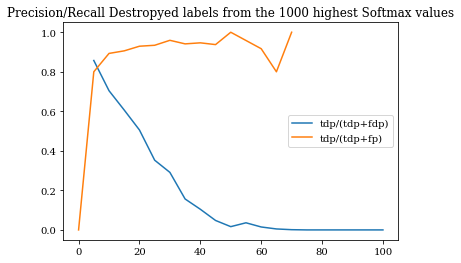

In [35]:
tp = np.array([i['TP'] for i in softmax_vals])
fp = np.array([i['FP'] for i in softmax_vals])
tdp = np.array([i['TDP'] for i in softmax_vals])
fdp = np.array([i['FDP'] for i in softmax_vals])

# Looking at the '1000' highest Softmax values b
plt.title(f"Precision/Recall Destropyed labels from the {num_samples} highest Softmax values")
plt.plot(percentages, tdp/(tdp+fdp), label="tdp/(tdp+fdp)")
plt.plot(percentages, tdp/(tdp+fp), label="tdp/(tdp+fp)")
plt.legend()

### Plot the Precision/Recall 
From all label predictions, get the precision and recall for the TDP

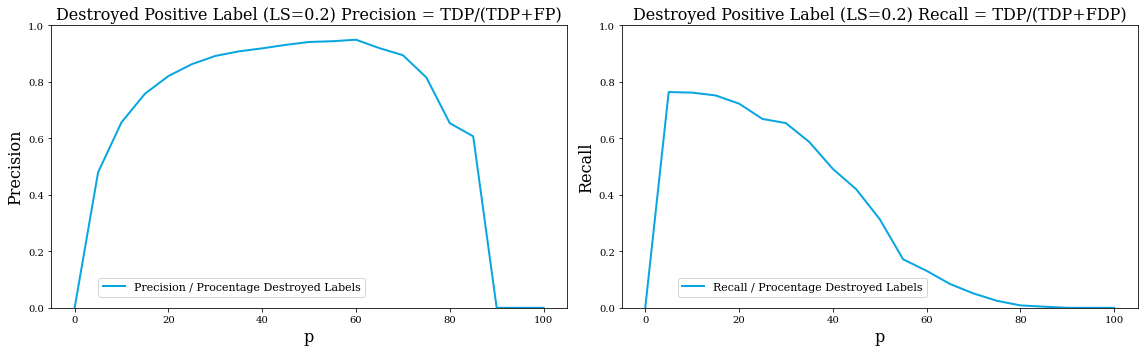

In [36]:
plt.rc('font', family='serif')
fig = plt.figure(figsize=(16, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

fontsize = 16
ax1.set_title(r"Destroyed Positive Label (LS=0.2) Precision = TDP/(TDP+FP)", fontsize=fontsize)
ax1.set_ylim(0, 1)
ax1.plot(percentages, destroyed_label_precision_scores, color="#08A6E1", linewidth=2, label="Precision / Procentage Destroyed Labels")
ax1.set_ylabel("Precision", fontsize=fontsize)
ax1.set_xlabel("p", fontsize=fontsize)
ax1.legend(loc="lower center", bbox_to_anchor=(0.35,0.02), fontsize=11)


ax2.set_title("Destroyed Positive Label (LS=0.2) Recall = TDP/(TDP+FDP)", fontsize=fontsize)
ax2.set_ylim(0, 1)
ax2.plot(percentages, destroyed_label_recall_scores, color="#08A6E1", linewidth=2, label="Recall / Procentage Destroyed Labels")
ax2.set_ylabel("Recall", fontsize=fontsize)
ax2.set_xlabel("p", fontsize=fontsize)
ax2.legend(loc="lower center", bbox_to_anchor=(0.35,0.02), fontsize=11)



plt.tight_layout()    
plt.show()

# fig.savefig("/workspace/data/TDP-precision-recall.jpg")

### Plot Histogram of the Softmax values for the different labels
The plot is the Softmax values from the last epoch of one of the runs and all of the labels

In [38]:
with open("/workspace/data/imdb-seed-42-ls-00/seed-42-p-020.json", 'r') as f:
    d = json.load(f)

TN, inv_TN, FN, inv_FN, TP, inv_TP, FP, inv_FP, FDP, inv_FDP, TDP, inv_TDP, = store_predictions(d)

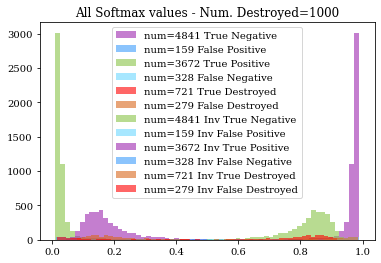

In [10]:
plt.figure()
plt.title("All Softmax values - Num. Destroyed=1000")
# Predicted labels
plt.hist(TN[-1],      alpha=0.6, bins=30, color="#9D28B0", label=f"num={len(TN[-1])} True Negative");     
plt.hist(FP[-1],      alpha=0.6, bins=30, color="#3e9efc", label=f"num={len(FP[-1])} False Positive");  
plt.hist(TP[-1],      alpha=0.6, bins=30, color="#8AC348", label=f"num={len(TP[-1])} True Positive");    
plt.hist(FN[-1],    alpha=0.6, bins=30, color="#6dd7ff", label=f"num={len(FN[-1])} False Negative"); 
plt.hist(TDP[-1],     alpha=0.6, bins=30, color="r",       label=f"num={len(TDP[-1])} True Destroyed");    
plt.hist(FDP[-1],     alpha=0.6, bins=30, color="#d9681c", label=f"num={len(FDP[-1])} False Destroyed");  

# Inverse
plt.hist(inv_TN[-1],  alpha=0.6, bins=30, color="#8AC348", label=f"num={len(inv_TN[-1])} Inv True Negative");  
plt.hist(inv_FP[-1],  alpha=0.6, bins=30, color="#6dd7ff", label=f"num={len(inv_FP[-1])} Inv False Positive");  
plt.hist(inv_TP[-1],  alpha=0.6, bins=30, color="#9D28B0", label=f"num={len(inv_TP[-1])} Inv True Positive");
plt.hist(inv_FN[-1],  alpha=0.6, bins=30, color="#3e9efc", label=f"num={len(inv_FN[-1])} Inv False Negative");   
plt.hist(inv_TDP[-1], alpha=0.6, bins=30, color="#d9681c", label=f"num={len(inv_TDP[-1])} Inv True Destroyed"); 
plt.hist(inv_FDP[-1], alpha=0.6, bins=30, color="r",       label=f"num={len(inv_FDP[-1])} Inv False Destroyed");       
plt.legend();

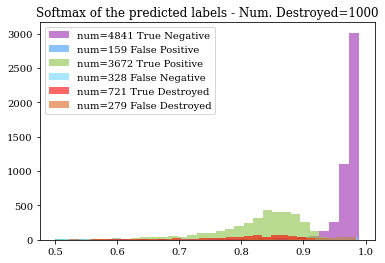

In [11]:
plt.figure()
plt.title("Softmax of the predicted labels - Num. Destroyed=1000")
# Predicted labels
plt.hist(TN[-1],      alpha=0.6, bins=30, color="#9D28B0", label=f"num={len(TN[-1])} True Negative");     
plt.hist(FP[-1],      alpha=0.6, bins=30, color="#3e9efc", label=f"num={len(FP[-1])} False Positive");  
plt.hist(TP[-1],      alpha=0.6, bins=30, color="#8AC348", label=f"num={len(TP[-1])} True Positive");     
plt.hist(FN[-1],      alpha=0.6, bins=30, color="#6dd7ff", label=f"num={len(FN[-1])} False Negative");  
plt.hist(TDP[-1],     alpha=0.6, bins=30, color="r",       label=f"num={len(TDP[-1])} True Destroyed");      
plt.hist(FDP[-1],     alpha=0.6, bins=30, color="#d9681c", label=f"num={len(FDP[-1])} False Destroyed");  
plt.legend();

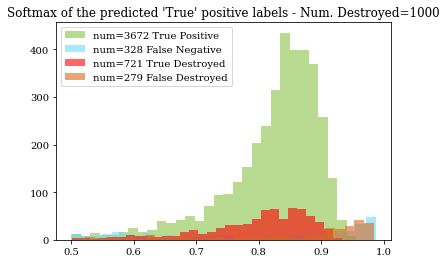

In [12]:
plt.figure()
plt.title("Softmax of the predicted 'True' positive labels - Num. Destroyed=1000")
# Predicted labels 
plt.hist(TP[-1],      alpha=0.6, bins=30, color="#8AC348", label=f"num={len(TP[-1])} True Positive");      
plt.hist(FN[-1],      alpha=0.6, bins=30, color="#6dd7ff", label=f"num={len(FN[-1])} False Negative"); 
plt.hist(TDP[-1],     alpha=0.6, bins=30, color="r",       label=f"num={len(TDP[-1])} True Destroyed");    
plt.hist(FDP[-1],     alpha=0.6, bins=30, color="#d9681c", label=f"num={len(FDP[-1])} False Destroyed"); 
plt.legend();

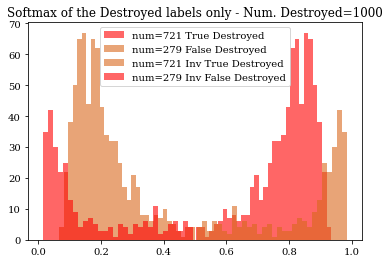

In [13]:
plt.figure()
plt.title("Softmax of the Destroyed labels only - Num. Destroyed=1000")
plt.hist(TDP[-1],     alpha=0.6, bins=30, color="r",       label=f"num={len(TDP[-1])} True Destroyed");        
plt.hist(FDP[-1],     alpha=0.6, bins=30, color="#d9681c", label=f"num={len(FDP[-1])} False Destroyed");
plt.hist(inv_TDP[-1], alpha=0.6, bins=30, color="#d9681c", label=f"num={len(inv_TDP[-1])} Inv True Destroyed");  
plt.hist(inv_FDP[-1], alpha=0.6, bins=30, color="r",       label=f"num={len(inv_FDP[-1])} Inv False Destroyed"); 
plt.legend();